<a href="https://colab.research.google.com/github/c1rodrigues/tch4/blob/main/tch4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

from prophet import Prophet

In [ ]:
df = pd.read_html('http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view', encoding='UTF-8', decimal=',', thousands='.')

In [ ]:
df_petroleo = df[2]

In [ ]:
df_petroleo.reset_index(drop=True, inplace=True)

In [ ]:
new_header = ['data','preco_petroleo']
df_petroleo = df_petroleo[1:]
df_petroleo.columns = new_header

In [ ]:
df_petroleo['data'] = pd.to_datetime(df_petroleo['data'])

In [ ]:
df_petroleo['preco_petroleo'] =  df_petroleo['preco_petroleo'].astype(float)

In [ ]:
df_petroleo.isnull().sum()

data              0
preco_petroleo    0
dtype: int64

In [ ]:
df_petroleo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11169 entries, 1 to 11169
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   data            11169 non-null  datetime64[ns]
 1   preco_petroleo  11169 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 174.6 KB


In [ ]:
df_petroleo[(df_petroleo['data'] >='2014-01-01') & (df_petroleo['data'] < '2024-01-01')]

,data,preco_petroleo
93,2023-12-29,77.69
94,2023-12-28,79.04
95,2023-12-27,80.97
96,2023-12-26,80.23
97,2023-12-22,80.23
...,...,...
3139,2014-01-07,106.57
3140,2014-01-06,107.94
3141,2014-01-04,109.95
3142,2014-01-03,110.47


In [ ]:
fig = px.line(df_petroleo, x = 'data', y = 'preco_petroleo', template='plotly_white')
fig.update_layout( title="Evoluçaõ do Petróleo Brent",
    xaxis_title=" ",
    yaxis_title="Dolares por Barril")
fig.show()

Primeira grande alta foi em Outubro de 1990. Essa alta se deu por conta da guerra entre Iraque e Kwait.

A segunda grande alta se deu em Julho de 2008 devido a atrasos no potencial retorno do petróleo iraniano aos mercados globais e a considerações dos Estados Unidos e aliados europeus de proibir importações de petróleo russo.

As negociações para reviver o acordo nuclear de 2015 do Irã com as potências mundiais produziram a queda do valor do barril do petróleo

Em Outubro 2018 vemos uma queda brusca decorrente do assassinado do jornalista saudita Jamal Khashoggi, crítico do príncipe-herdeiro Mohamed bin Salman e exilado nos Estados Unidos.

Depois disso temos a queda de Abril de 2020, decorrente do início da pandemia do COVID-19 e os dois picos de Março e Julho de 2022 decorrentes da Guerra entre Ucrânia e Rússia.

In [ ]:
df_ajustado = df_petroleo.set_index('data', drop=True)

In [ ]:
df_ajustado

,preco_petroleo
data,
2024-05-13,83.18
2024-05-10,83.39
2024-05-09,83.27
2024-05-08,82.44
2024-05-07,82.69
...,...
1987-05-26,18.63
1987-05-25,18.60
1987-05-22,18.55


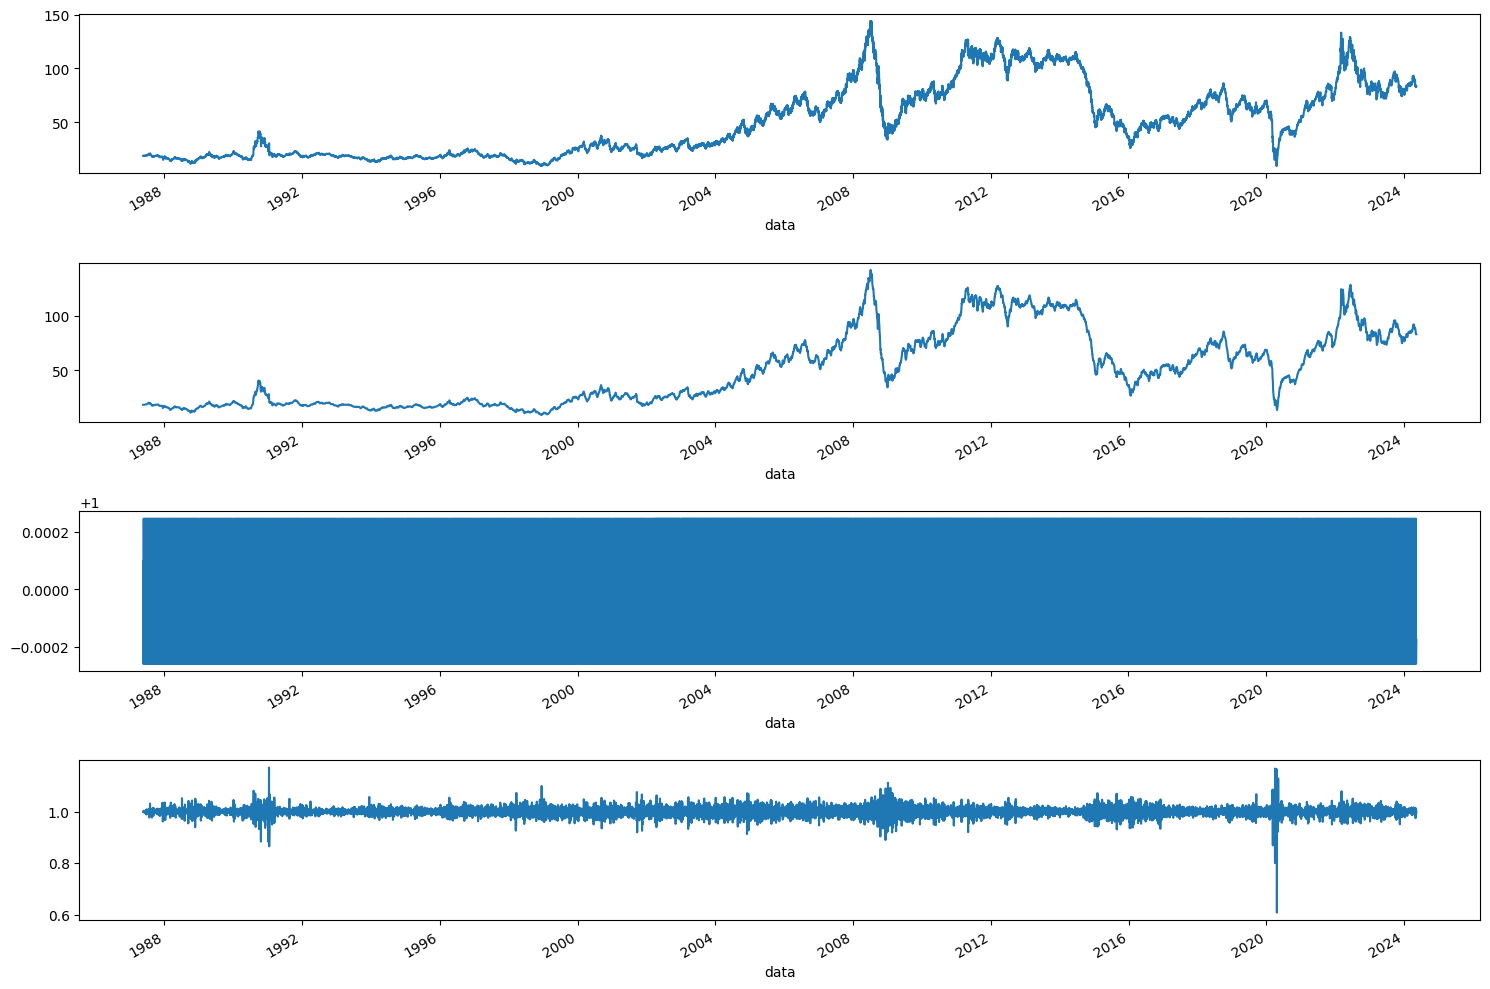

In [ ]:
resultados = seasonal_decompose(df_ajustado, period = 5, model='multiplicative')


fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize = (15,10))

resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)

plt.tight_layout()

In [ ]:
X  = df_ajustado.preco_petroleo.values

In [ ]:
result = adfuller(X)

print("Teste ADF")
print(f"Teste Estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print("Valores críticos:")

for key, value in result[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -2.0283021340122205
P-Value: 0.2743031022931673
Valores críticos:
	1%: -3.430937304289178
	5%: -2.8617995564781373
	10%: -2.5669081567946774


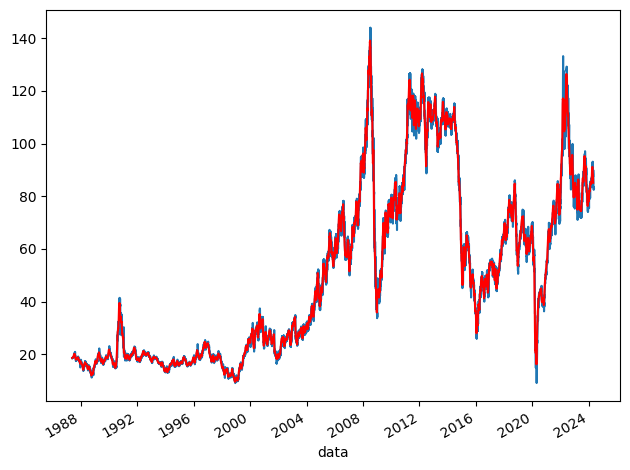

In [ ]:
ma = df_ajustado.rolling(12).mean()


f, ax = plt.subplots()
df_ajustado.plot (ax=ax, legend = False)
ma.plot (ax=ax, legend = False, color = 'r')


plt.tight_layout()

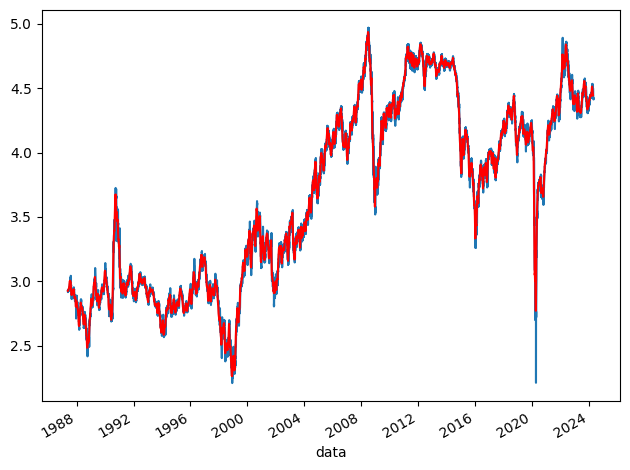

In [ ]:
df_ajustado_log = np.log(df_ajustado)
ma_log = df_ajustado_log.rolling(12).mean()

f, ax = plt.subplots()
df_ajustado_log.plot (ax=ax, legend = False)
ma_log.plot (ax=ax, legend = False, color = 'r')


plt.tight_layout()

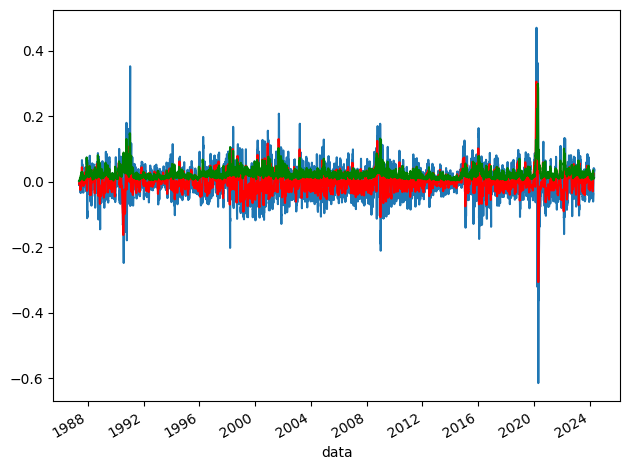

In [ ]:
df_s = (df_ajustado_log - ma_log ).dropna()

ma_s = df_s.rolling(12).mean()

std = df_s.rolling(12).std()

f, ax = plt.subplots()
df_s.plot (ax=ax, legend = False)
ma_s.plot (ax=ax, legend = False, color = 'r')
std.plot (ax=ax, legend = False, color = 'g')

plt.tight_layout()

In [ ]:
X_s  = df_s.preco_petroleo.values

In [ ]:
result_s = adfuller(X_s)

print("Teste ADF")
print(f"Teste Estatístico: {result_s[0]}")
print(f"P-Value: {result_s[1]}")
print("Valores críticos:")

for key, value in result_s[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -17.653429031740107
P-Value: 3.7109073578018764e-30
Valores críticos:
	1%: -3.430937620939872
	5%: -2.861799696406638
	10%: -2.566908231278257


Teste ADF
Teste Estatístico: -24.54984597111898
P-Value: 0.0
Valores críticos:
	1%: -3.430938414062469
	5%: -2.8618000468888494
	10%: -2.566908417839044


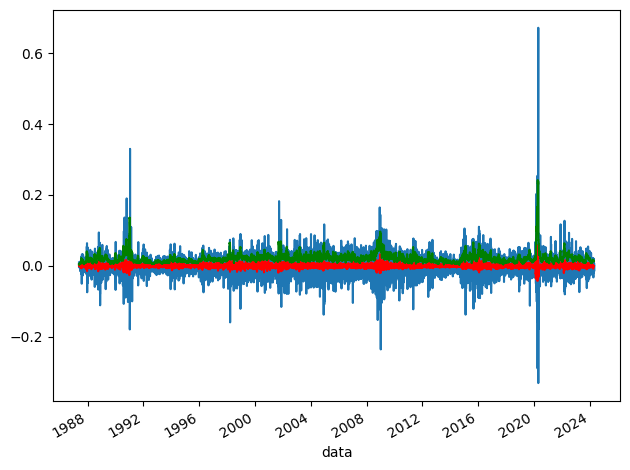

In [ ]:
df_diff = df_s.diff(1)
ma_diff = df_diff.rolling(12).mean()

std_diff = df_diff.rolling(12).std()

f, ax = plt.subplots()
df_diff.plot (ax=ax, legend = False)
ma_diff.plot (ax=ax, legend = False, color = 'r')
std_diff.plot (ax=ax, legend = False, color = 'g')

plt.tight_layout()

X_diff  = df_diff.preco_petroleo.dropna().values

result_diff = adfuller(X_diff)

print("Teste ADF")
print(f"Teste Estatístico: {result_diff[0]}")
print(f"P-Value: {result_diff[1]}")
print("Valores críticos:")

for key, value in result_diff[4].items():
  print(f"\t{key}: {value}")

In [ ]:
lag_acf = acf(df_diff.dropna(), nlags = 25)
lag_pacf = pacf(df_diff.dropna(), nlags = 25)

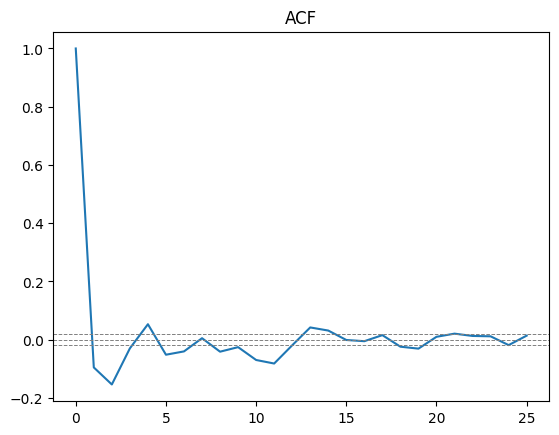

In [ ]:
plt.plot(lag_acf)

plt.axhline(y= -1.96/(np.sqrt((len(df_diff) -1))), linestyle = '--', color = 'gray', linewidth = .7)
plt.axhline(y= 0, linestyle = '--', color = 'gray', linewidth = .7)
plt.axhline(y= 1.96/(np.sqrt((len(df_diff) -1))), linestyle = '--', color = 'gray', linewidth = .7)

plt.title("ACF")

plt.show()

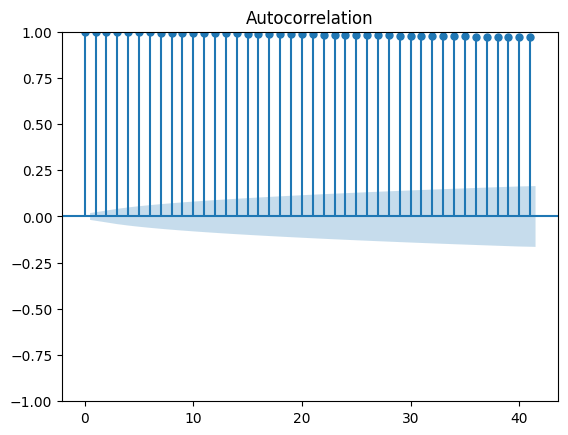

In [ ]:
plot_acf(df_ajustado.preco_petroleo)

plt.show()

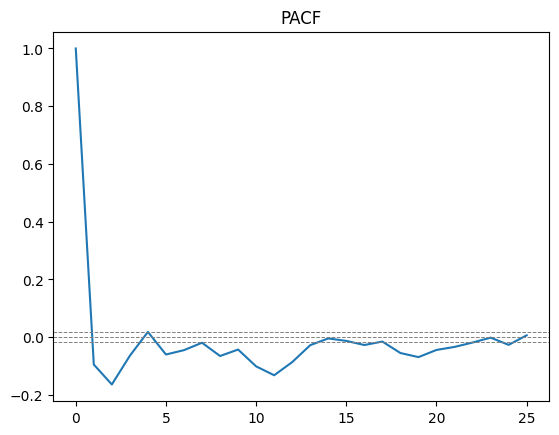

In [ ]:
plt.plot(lag_pacf)

plt.axhline(y= -1.96/(np.sqrt((len(df_diff) -1))), linestyle = '--', color = 'gray', linewidth = .7)
plt.axhline(y= 0, linestyle = '--', color = 'gray', linewidth = .7)
plt.axhline(y= 1.96/(np.sqrt((len(df_diff) -1))), linestyle = '--', color = 'gray', linewidth = .7)

plt.title("PACF")

plt.show()

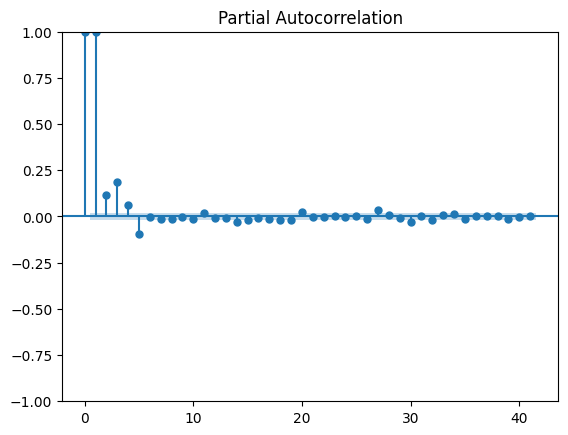

In [ ]:
plot_pacf(df_ajustado.preco_petroleo)

plt.show()

In [ ]:
df = df_petroleo[(df_petroleo['data'] >'2014-01-01') & (df_petroleo['data'] <= '2024-01-01')]
df = df.reset_index()
df.drop(columns=['index'], inplace=True)
# Renomeando as colunas para 'ds' e 'y'
df = df.rename(columns={'data': 'ds', 'preco_petroleo': 'y'})
#df[['ds','y']] = df[['data','preco_petroleo']]
df.tail()

,ds,y
3046,2014-01-07,106.57
3047,2014-01-06,107.94
3048,2014-01-04,109.95
3049,2014-01-03,110.47
3050,2014-01-02,107.94


In [ ]:
#train_data = df.sample(frac=0.8, random_state=0)
#test_data = df.drop(train_data.index)

# Dividindo os dados em treinamento, validação e teste
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.15)
test_size = len(df) - train_size - val_size

train_data, test_and_val_data = np.split(df, [train_size])
val_data, test_data = np.split(test_and_val_data, [val_size])


print(f'training data size : {train_data.shape}')
print(f'testing data size : {test_data.shape}')

training data size : (2135, 2)
testing data size : (459, 2)


In [ ]:
train_data

,ds,y
0,2023-12-29,77.69
1,2023-12-28,79.04
2,2023-12-27,80.97
3,2023-12-26,80.23
4,2023-12-22,80.23
...,...,...
2130,2016-07-13,44.67
2131,2016-07-12,46.72
2132,2016-07-11,44.53
2133,2016-07-10,45.93


In [ ]:
modelo = Prophet(daily_seasonality=True)
modelo.fit(train_data)
dataFramefuture = modelo.make_future_dataframe(periods=20, freq='M')
previsao = modelo.predict(dataFramefuture)
previsao.tail()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpk5y2pxm9/97m6rox0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk5y2pxm9/_vx5o400.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70624', 'data', 'file=/tmp/tmpk5y2pxm9/97m6rox0.json', 'init=/tmp/tmpk5y2pxm9/_vx5o400.json', 'output', 'file=/tmp/tmpk5y2pxm9/prophet_modeljevw61h4/prophet_model-20240519004925.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:49:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:49:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2150,2025-03-31,52.155556,24.620073,76.438471,28.225288,76.071682,-1.484472,-1.484472,-1.484472,0.697517,...,0.257822,0.257822,0.257822,-2.439811,-2.439811,-2.439811,0.0,0.0,0.0,50.671084
2151,2025-04-30,50.716803,21.196490,77.690817,24.873808,76.849350,-1.804031,-1.804031,-1.804031,0.697517,...,0.041207,0.041207,0.041207,-2.542755,-2.542755,-2.542755,0.0,0.0,0.0,48.912771
2152,2025-05-31,49.230091,19.795838,82.546436,20.607777,77.630877,2.208615,2.208615,2.208615,0.697517,...,-0.592221,-0.592221,-0.592221,2.103319,2.103319,2.103319,0.0,0.0,0.0,51.438706
2153,2025-06-30,47.791338,17.616065,83.206488,16.771765,78.768576,2.670949,2.670949,2.670949,0.697517,...,0.257822,0.257822,0.257822,1.715610,1.715610,1.715610,0.0,0.0,0.0,50.462287
2154,2025-07-31,46.304626,11.926334,81.624168,12.651799,80.336943,0.873199,0.873199,0.873199,0.697517,...,-0.024961,-0.024961,-0.024961,0.200643,0.200643,0.200643,0.0,0.0,0.0,47.177825


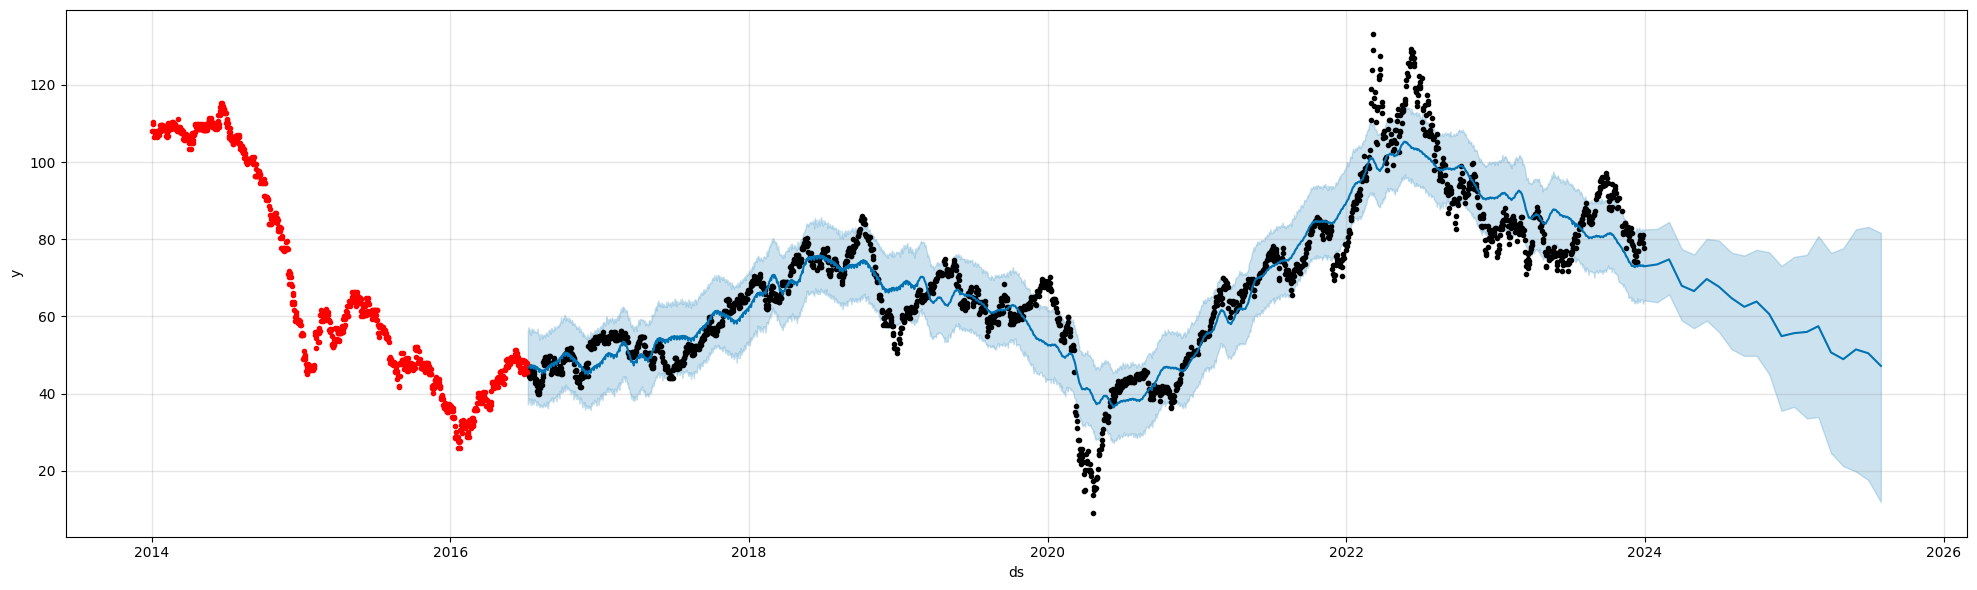

In [ ]:
modelo.plot(previsao, figsize=(20,6));
plt.plot(test_and_val_data['ds'], test_and_val_data['y'], '.r')

In [ ]:
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao[previsao_cols]
valores_reais = test_and_val_data[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

# Calcular o MAPE
mape = np.mean(resultados['erro_percentual_absoluto'])

print(f"MAPE: {mape:.2f}%")

MAPE: nan%
